## Reading In All Necessary Libraries

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from umap.umap_ import UMAP
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## Reading in the Data

In [5]:
df = pd.read_csv("Tachycardia.txt", delimiter=" ")
df_num = df.drop(['BPMEDS', 'PERIOD', 'RANDID', 'CURSMOKE'], axis = 1)


In [21]:
X = df.drop(['DIABETES', 'BPMEDS', 'PERIOD', 'RANDID', 'CURSMOKE'], axis = 1)
y = df['DIABETES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=307)

df_merged = X_test.merge(y_test, left_index=True, right_index=True)


      SEX  TOTCHOL  AGE  SYSBP  DIABP    BMI  HEARTRTE  GLUCOSE  DIABETES
1760    2      276   75  195.0   92.0  20.35        72      118         0
4616    2      266   52  127.0   79.0  21.25        83       73         0
891     2      245   35  148.0   84.0  23.74        60       73         0
4888    1      285   50  166.0  108.0  22.36        85       76         0
2909    1      216   56  108.0   77.0  30.85        85       93         0
...   ...      ...  ...    ...    ...    ...       ...      ...       ...
2401    2      282   56  129.0   88.0  26.12        80       80         0
4539    1      351   58  130.0   77.5  31.84        88       80         0
554     1      214   62  181.0   90.0  31.51       102      151         1
1547    1      220   53  146.0   81.0  30.53       105      100         0
74      1      216   56  117.0   70.0  21.35        72       49         0

[1301 rows x 9 columns]


## Exploratory Data Analysis

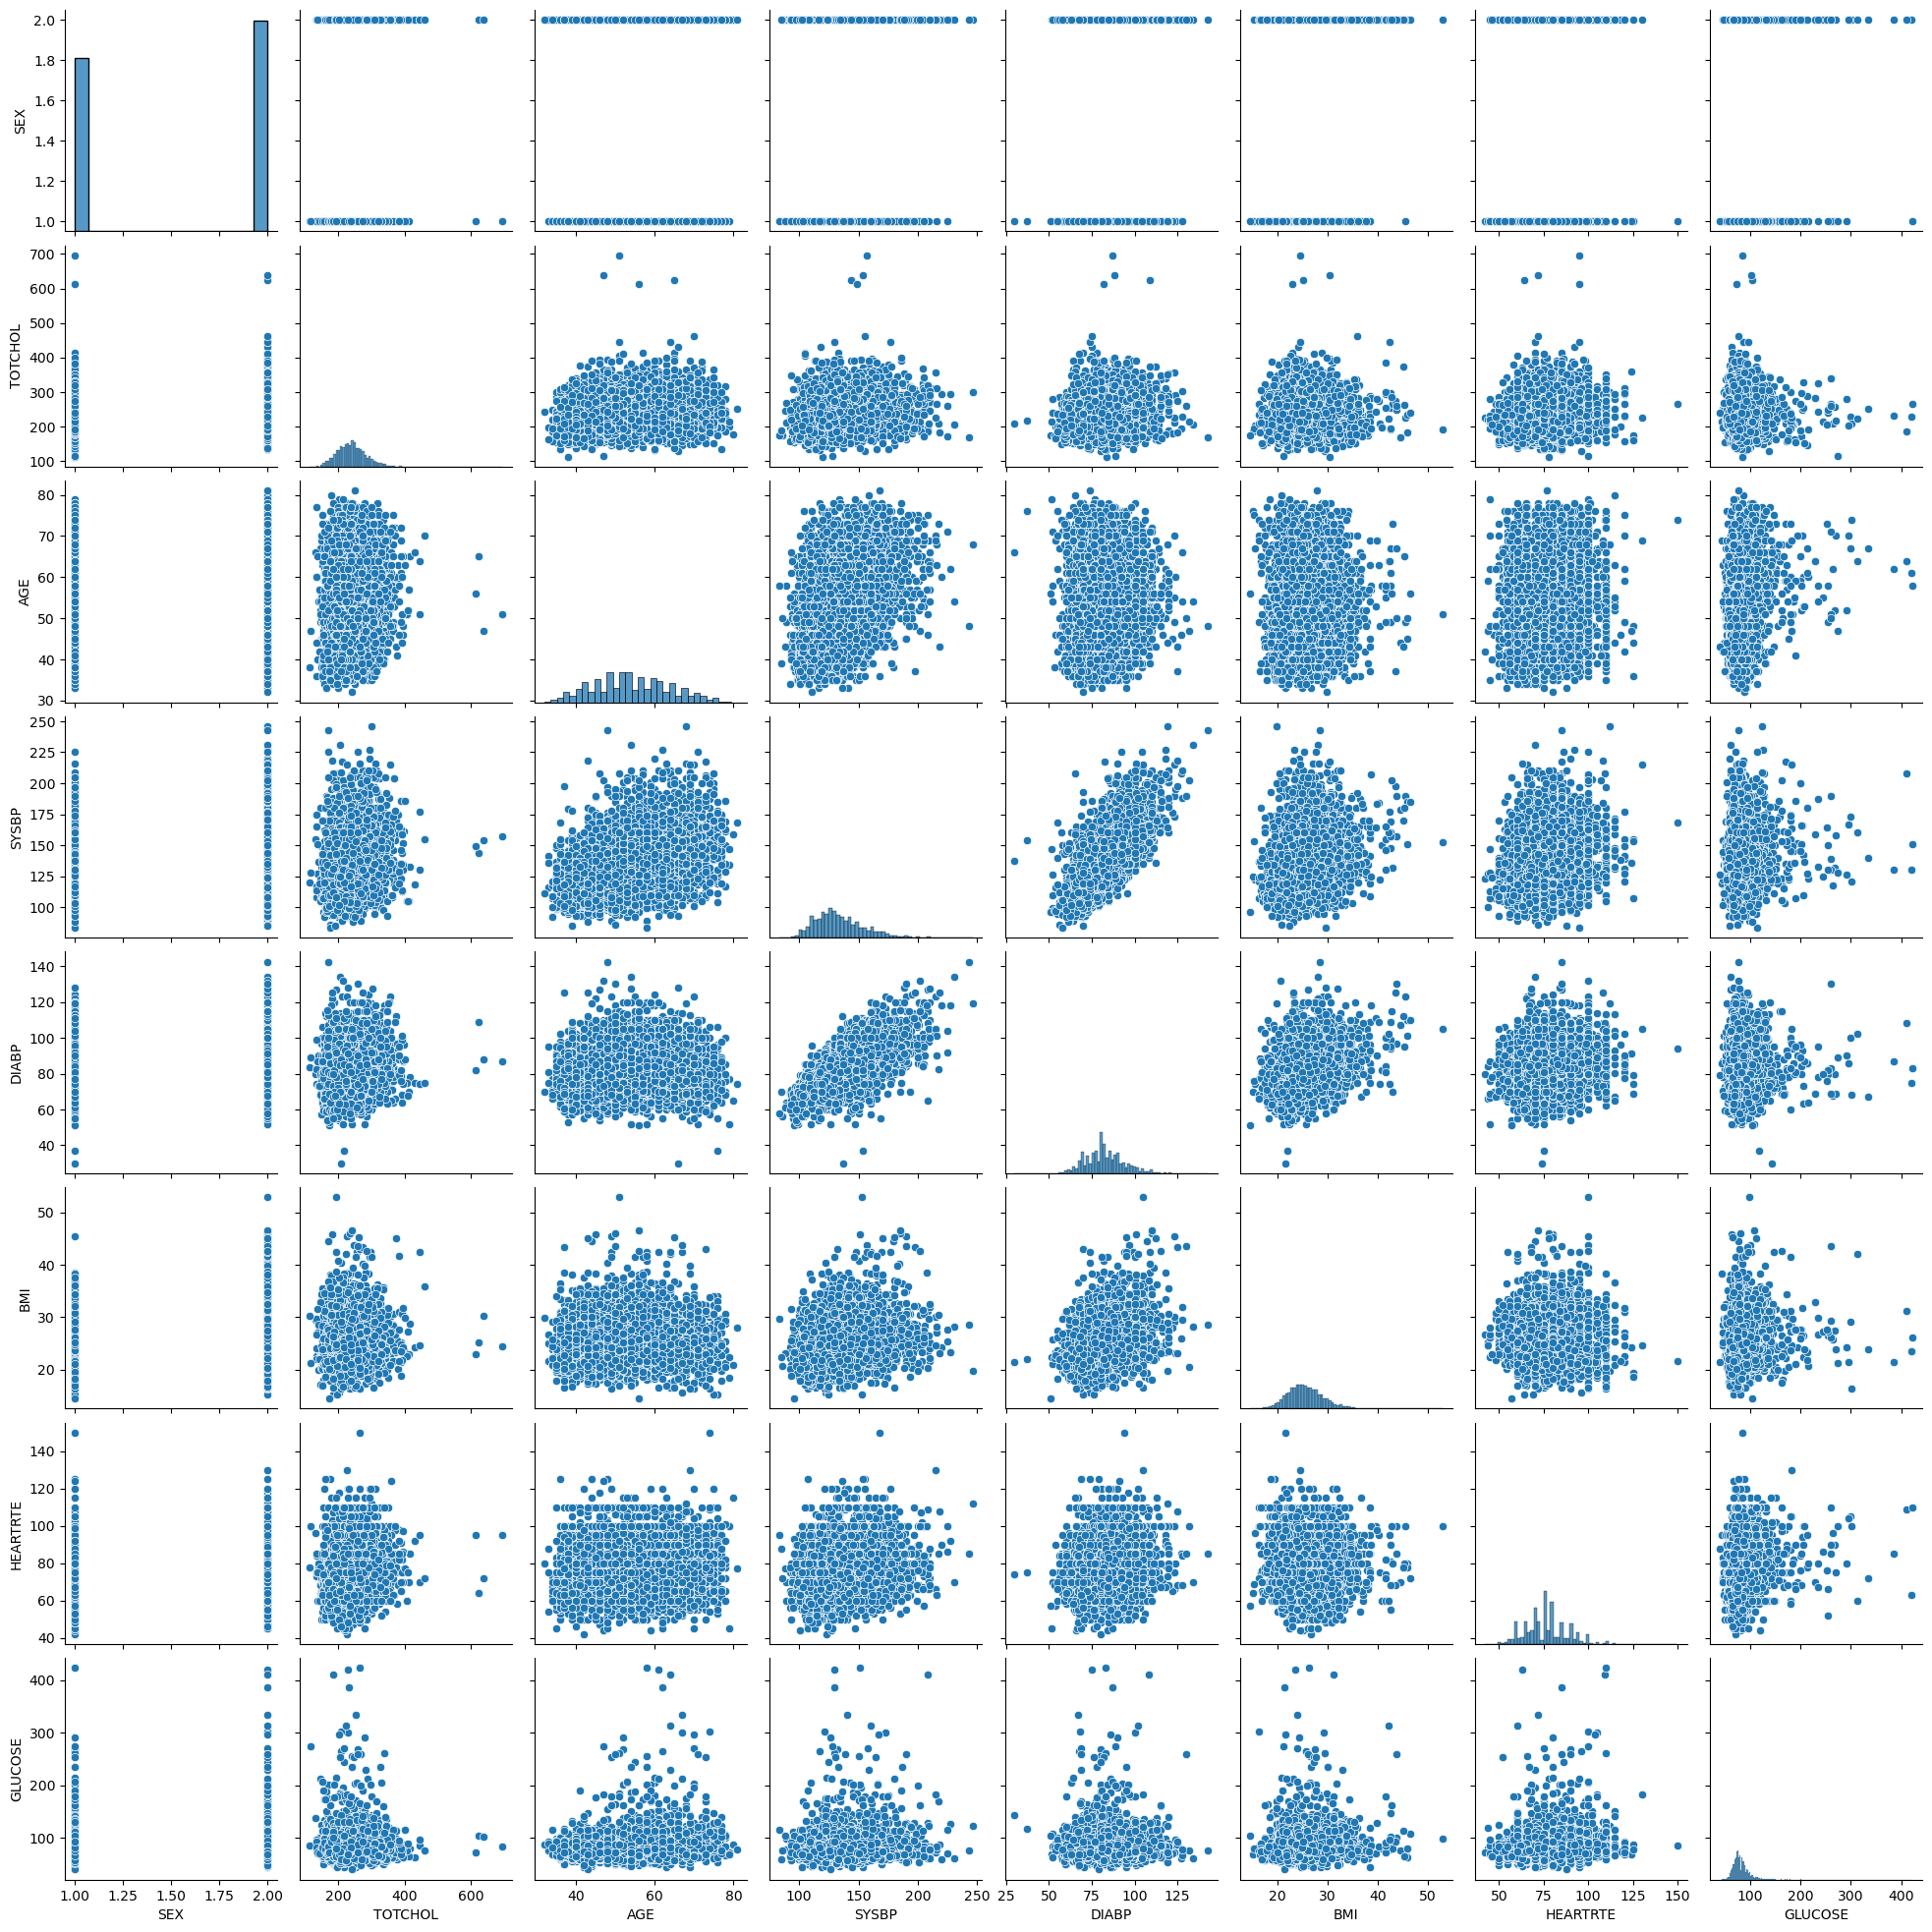

In [73]:
sns.pairplot(X)

<Axes: xlabel='SYSBP', ylabel='DIABP'>

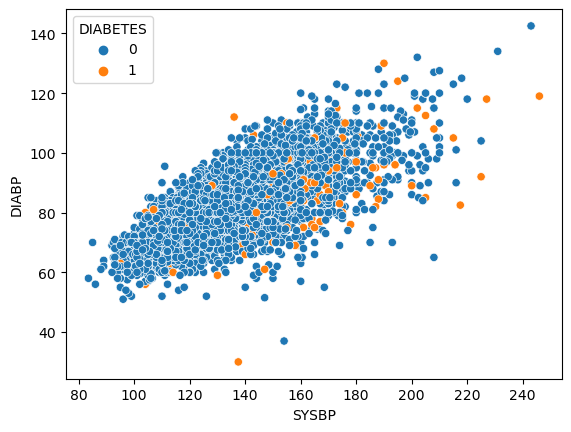

In [20]:
sns.scatterplot(data = df, x = "SYSBP", y = "DIABP", hue = "DIABETES")

<Axes: xlabel='DIABETES', ylabel='BMI'>

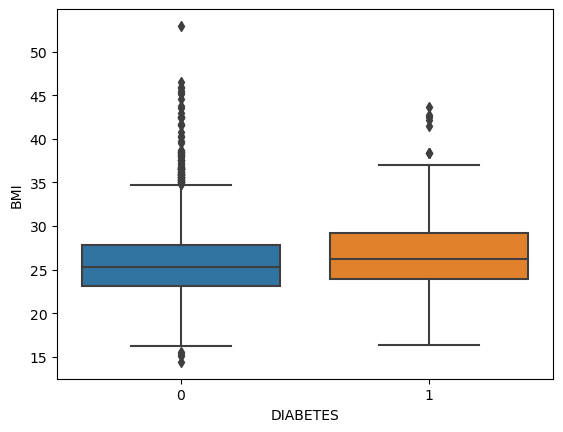

In [19]:
sns.boxplot(data=df, x = "DIABETES", y = "BMI")

<Axes: xlabel='DIABETES', ylabel='AGE'>

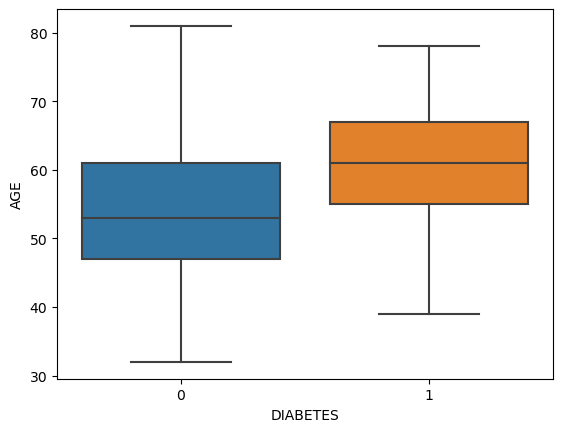

In [21]:
sns.boxplot(data = df, x = "DIABETES", y = "AGE")

<Axes: xlabel='DIABETES', ylabel='TOTCHOL'>

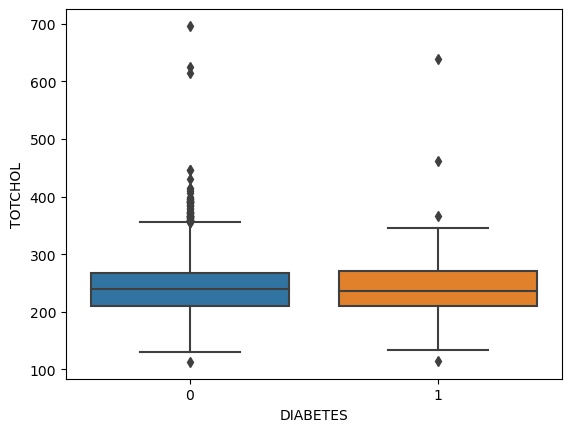

In [22]:
sns.boxplot(data=df, x = 'DIABETES', y = 'TOTCHOL')

<Axes: xlabel='DIABETES', ylabel='HEARTRTE'>

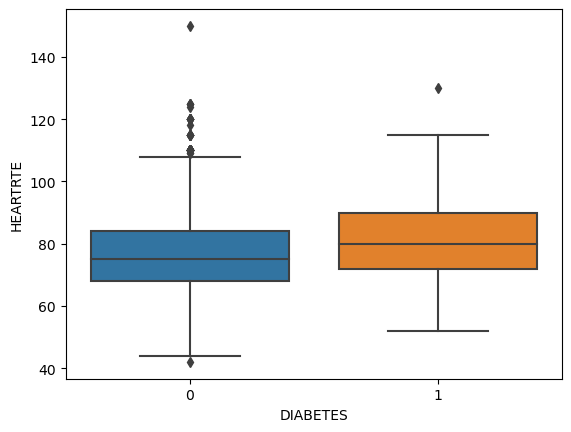

In [23]:
sns.boxplot(data=df, x = 'DIABETES', y = 'HEARTRTE')

<Axes: xlabel='DIABETES', ylabel='GLUCOSE'>

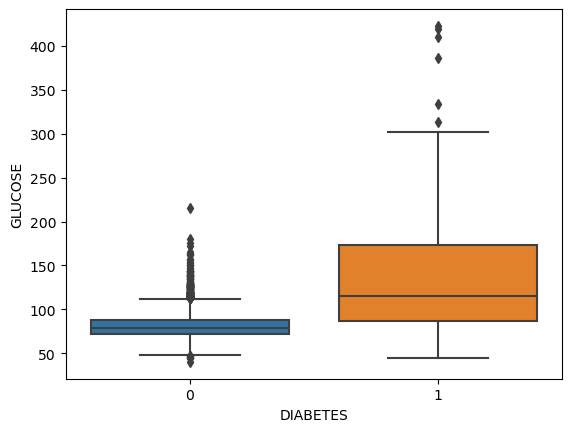

In [24]:
sns.boxplot(data=df, x = 'DIABETES', y = 'GLUCOSE')

## Machine Learning Models

### AdaBoost Classifier with Decision Tree Base

In [43]:
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

model = AdaBoostClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 51}


In [68]:
base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_classifier = AdaBoostClassifier(estimator=base_estimator)

adaboost_classifier.fit(X_train, y_train)

y_pred = adaboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)

confusion_matrix(y_test, y_pred)

Accuracy: 0.973097617217525
Test F1 Score: 0.4927536231884059


array([[1249,    5],
       [  30,   17]])

### Gradient Boosting Classifier

In [ ]:
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

model = GradientBoostingClassifier()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

In [7]:
gb_classifier = GradientBoostingClassifier()

gb_classifier.fit(X_train, y_train)

y_pred = gb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)

confusion_matrix(y_test, y_pred)

Accuracy: 0.9738662567255957
Test F1 Score: 0.5405405405405406


array([[1247,    7],
       [  27,   20]])

### Support Vector Machine 

In [20]:
svm = SVC()

param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': randint(2, 5)
}

random_search = RandomizedSearchCV(
    svm, param_distributions=param_dist, n_iter=10, cv=5, random_state=42
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Model:", test_accuracy)

In [82]:
svm_classifier = SVC(kernel='rbf', random_state=42)

svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)

confusion_matrix(y_test, y_pred)

Accuracy: 0.9707916986933128
Test F1 Score: 0.32142857142857145


array([[1254,    0],
       [  38,    9]])

### Random Forest Classifier

In [43]:
rf = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced'] 
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = random_search.best_estimator_

accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Best Hyperparameters: {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 111}
Accuracy: 0.9777094542659492


In [8]:
rf_classifier = RandomForestClassifier(bootstrap=True, max_depth=10, max_features= 'sqrt', min_samples_leaf=4, min_samples_split=8, n_estimators=111)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", f1)

confusion_matrix(y_test, y_pred)



Accuracy: 0.9769408147578785
Test F1 Score: 0.53125


array([[1254,    0],
       [  30,   17]])

## SHAP Explainer

In [17]:
explainer = shap.TreeExplainer(rf_classifier) # clf is the random forest
shap_values = explainer.shap_values(X_train.values)
exp = shap.Explanation(shap_values[1], explainer.expected_value[1], X_train.values, 
                       feature_names=X.columns) 

In [35]:
exp

.values =
array([[ 0.00327316, -0.00327316],
       [ 0.00085709, -0.00085709],
       [-0.03337464,  0.03337464],
       [-0.00470971,  0.00470971],
       [ 0.00432786, -0.00432786],
       [ 0.00837888, -0.00837888],
       [ 0.00601357, -0.00601357],
       [ 0.02107712, -0.02107712]])

.base_values =
0.03922302204793875

.data =
array([[  2.  , 333.  ,  57.  , ...,  26.09,  85.  ,  77.  ],
       [  2.  , 274.  ,  75.  , ...,  22.78,  76.  ,  85.  ],
       [  2.  , 201.  ,  45.  , ...,  22.31,  95.  ,  89.  ],
       ...,
       [  2.  , 319.  ,  54.  , ...,  21.68,  85.  ,  64.  ],
       [  2.  , 221.  ,  40.  , ...,  18.84,  64.  ,  73.  ],
       [  1.  , 208.  ,  54.  , ...,  25.53,  70.  , 136.  ]])

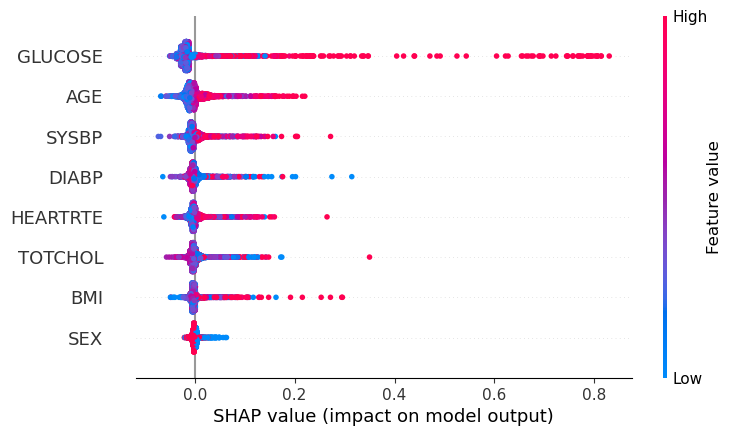

In [59]:
shap.plots.beeswarm(exp)

In [28]:
false_positive = (gb_classifier.predict(X_test) & ~y_test).astype(bool)
false_negative = (~gb_classifier.predict(X_test) & y_test).astype(bool)
true_positive = (gb_classifier.predict(X_test) & y_test).astype(bool)
true_negative = (~gb_classifier.predict(X_test) & ~y_test).astype(bool)

In [29]:
df_merged[true_positive].head()

SEX  TOTCHOL  AGE  SYSBP  DIABP    BMI  HEARTRTE  GLUCOSE  DIABETES
5195    1      238   58  174.0   83.0  23.65       105      180         1
3472    1      224   63  129.0   83.0  34.38        75      173         1
2738    1      201   60  170.0   98.0  23.72        75      180         1
1872    1      258   52  132.0   80.0  27.52        90      268         1
5022    2      326   54  187.0   95.0  29.94        67      235         1

In [30]:
df_merged[true_negative].head()

SEX  TOTCHOL  AGE  SYSBP  DIABP    BMI  HEARTRTE  GLUCOSE  DIABETES
1760    2      276   75  195.0   92.0  20.35        72      118         0
4616    2      266   52  127.0   79.0  21.25        83       73         0
891     2      245   35  148.0   84.0  23.74        60       73         0
4888    1      285   50  166.0  108.0  22.36        85       76         0
2909    1      216   56  108.0   77.0  30.85        85       93         0

In [31]:
df_merged[false_positive].head()

SEX  TOTCHOL  AGE  SYSBP  DIABP    BMI  HEARTRTE  GLUCOSE  DIABETES
4440    2      193   52  146.0   89.0  25.37       115       84         0
4416    1      186   39  162.0  109.0  29.72        90      129         0
1804    1      250   44  141.0  104.0  28.13       115       80         0
4195    1      293   55  164.0  101.0  27.18       115       67         0
1354    1      196   54  170.0   91.0  30.31        90      139         0

In [32]:
df_merged[false_negative].head()

SEX  TOTCHOL  AGE  SYSBP  DIABP    BMI  HEARTRTE  GLUCOSE  DIABETES
3643    1      133   60  117.0   83.0  21.97        85       93         1
3491    1      240   60  131.0   76.0  20.57        70       85         1
4000    1      300   58  160.0  100.0  33.39       110      121         1
847     1      292   60  195.0  124.0  23.12        80       97         1
5053    1      216   51  161.0   91.0  26.27        60      130         1

## Cluster Analysis

In [7]:
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(df_num)
                for k in range(1, 7)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[18000215.204284266,
 11412258.973107833,
 9436102.582745578,
 8376235.790553577,
 7278764.806158749,
 6568333.367243856]

/Users/huntercroxall/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/huntercroxall/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/huntercroxall/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/huntercroxall/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/clus

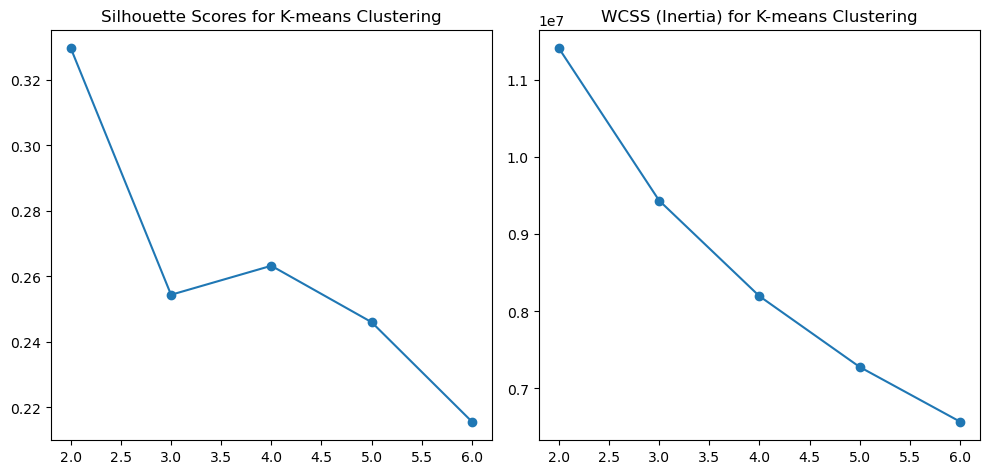

In [10]:
silhouette_scores = []
wcss_values = []

for n_clusters in range(2, 7):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_num)
    
    silhouette_avg = silhouette_score(df_num, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    wcss_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-means Clustering')

plt.subplot(1, 2, 2)
plt.plot(range(2, 7), wcss_values, marker='o')
plt.title('WCSS (Inertia) for K-means Clustering')

plt.tight_layout()
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(df_num)
y_kmeans = kmeans.predict(df_num)

kmeans.cluster_centers_

array([[1.67209302e+00, 3.13376744e+02, 5.64372093e+01, 1.40240698e+02,
        8.51139535e+01, 2.59381279e+01, 3.60465116e-02, 7.85348837e+01,
        8.22081395e+01, 5.94186047e-01],
       [1.49211165e+00, 1.94834345e+02, 5.08379854e+01, 1.25762136e+02,
        7.88965413e+01, 2.50625061e+01, 2.12378641e-02, 7.47038835e+01,
        8.14459951e+01, 2.54429612e+00],
       [1.53138298e+00, 2.50375000e+02, 5.34872340e+01, 1.27248404e+02,
        8.00234043e+01, 2.56191915e+01, 1.32978723e-02, 7.51553191e+01,
        7.82127660e+01, 2.83085106e+00],
       [1.57493857e+00, 2.38668305e+02, 5.97383292e+01, 1.62107494e+02,
        9.26670762e+01, 2.69334889e+01, 1.35135135e-01, 8.05958231e+01,
        1.02861179e+02, 2.99754300e+00]])

In [18]:
df_num['cluster'] = kmeans.labels_
df_num.groupby('cluster').agg(['mean', 'median', 'std'])

SEX                      TOTCHOL                          AGE  \
             mean median       std        mean median        std       mean   
cluster                                                                       
0        1.672093    2.0  0.469724  313.376744  305.0  35.271472  56.437209   
1        1.492112    1.0  0.500090  194.834345  198.0  19.433066  50.837985   
2        1.531350    2.0  0.499149  250.377790  250.0  16.596701  53.498937   
3        1.575123    2.0  0.494629  238.633005  238.0  23.566226  59.726601   

                               SYSBP  ...       BMI  DIABETES         \
        median       std        mean  ...       std      mean median   
cluster                               ...                              
0         56.0  8.820524  140.240698  ...  3.638519  0.036047    0.0   
1         50.0  9.773691  125.762136  ...  3.920466  0.021238    0.0   
2         53.0  8.859842  127.261424  ...  3.323454  0.013815    0.0   
3         60.0  8.707984  162.163177  ...  4.420534  0.134236    0.0   

                    HEARTRTE                       GLUCOSE                    
              std       mean median        std        mean median        std  
cluster                                                                       
0        0.186514  78.534884   77.5  12.157003   82.208140   79.0  17.110806  
1        0.144220  74.703883   75.0  11.542943   81.445995   79.0  15.829219  
2        0.116754  75.174283   75.0  11.292845   78.230606   77.0  12.155381  
3        0.341116  80.565271   80.0  13.421808  102.880542   92.0  42.638465  

[4 rows x 27 columns]

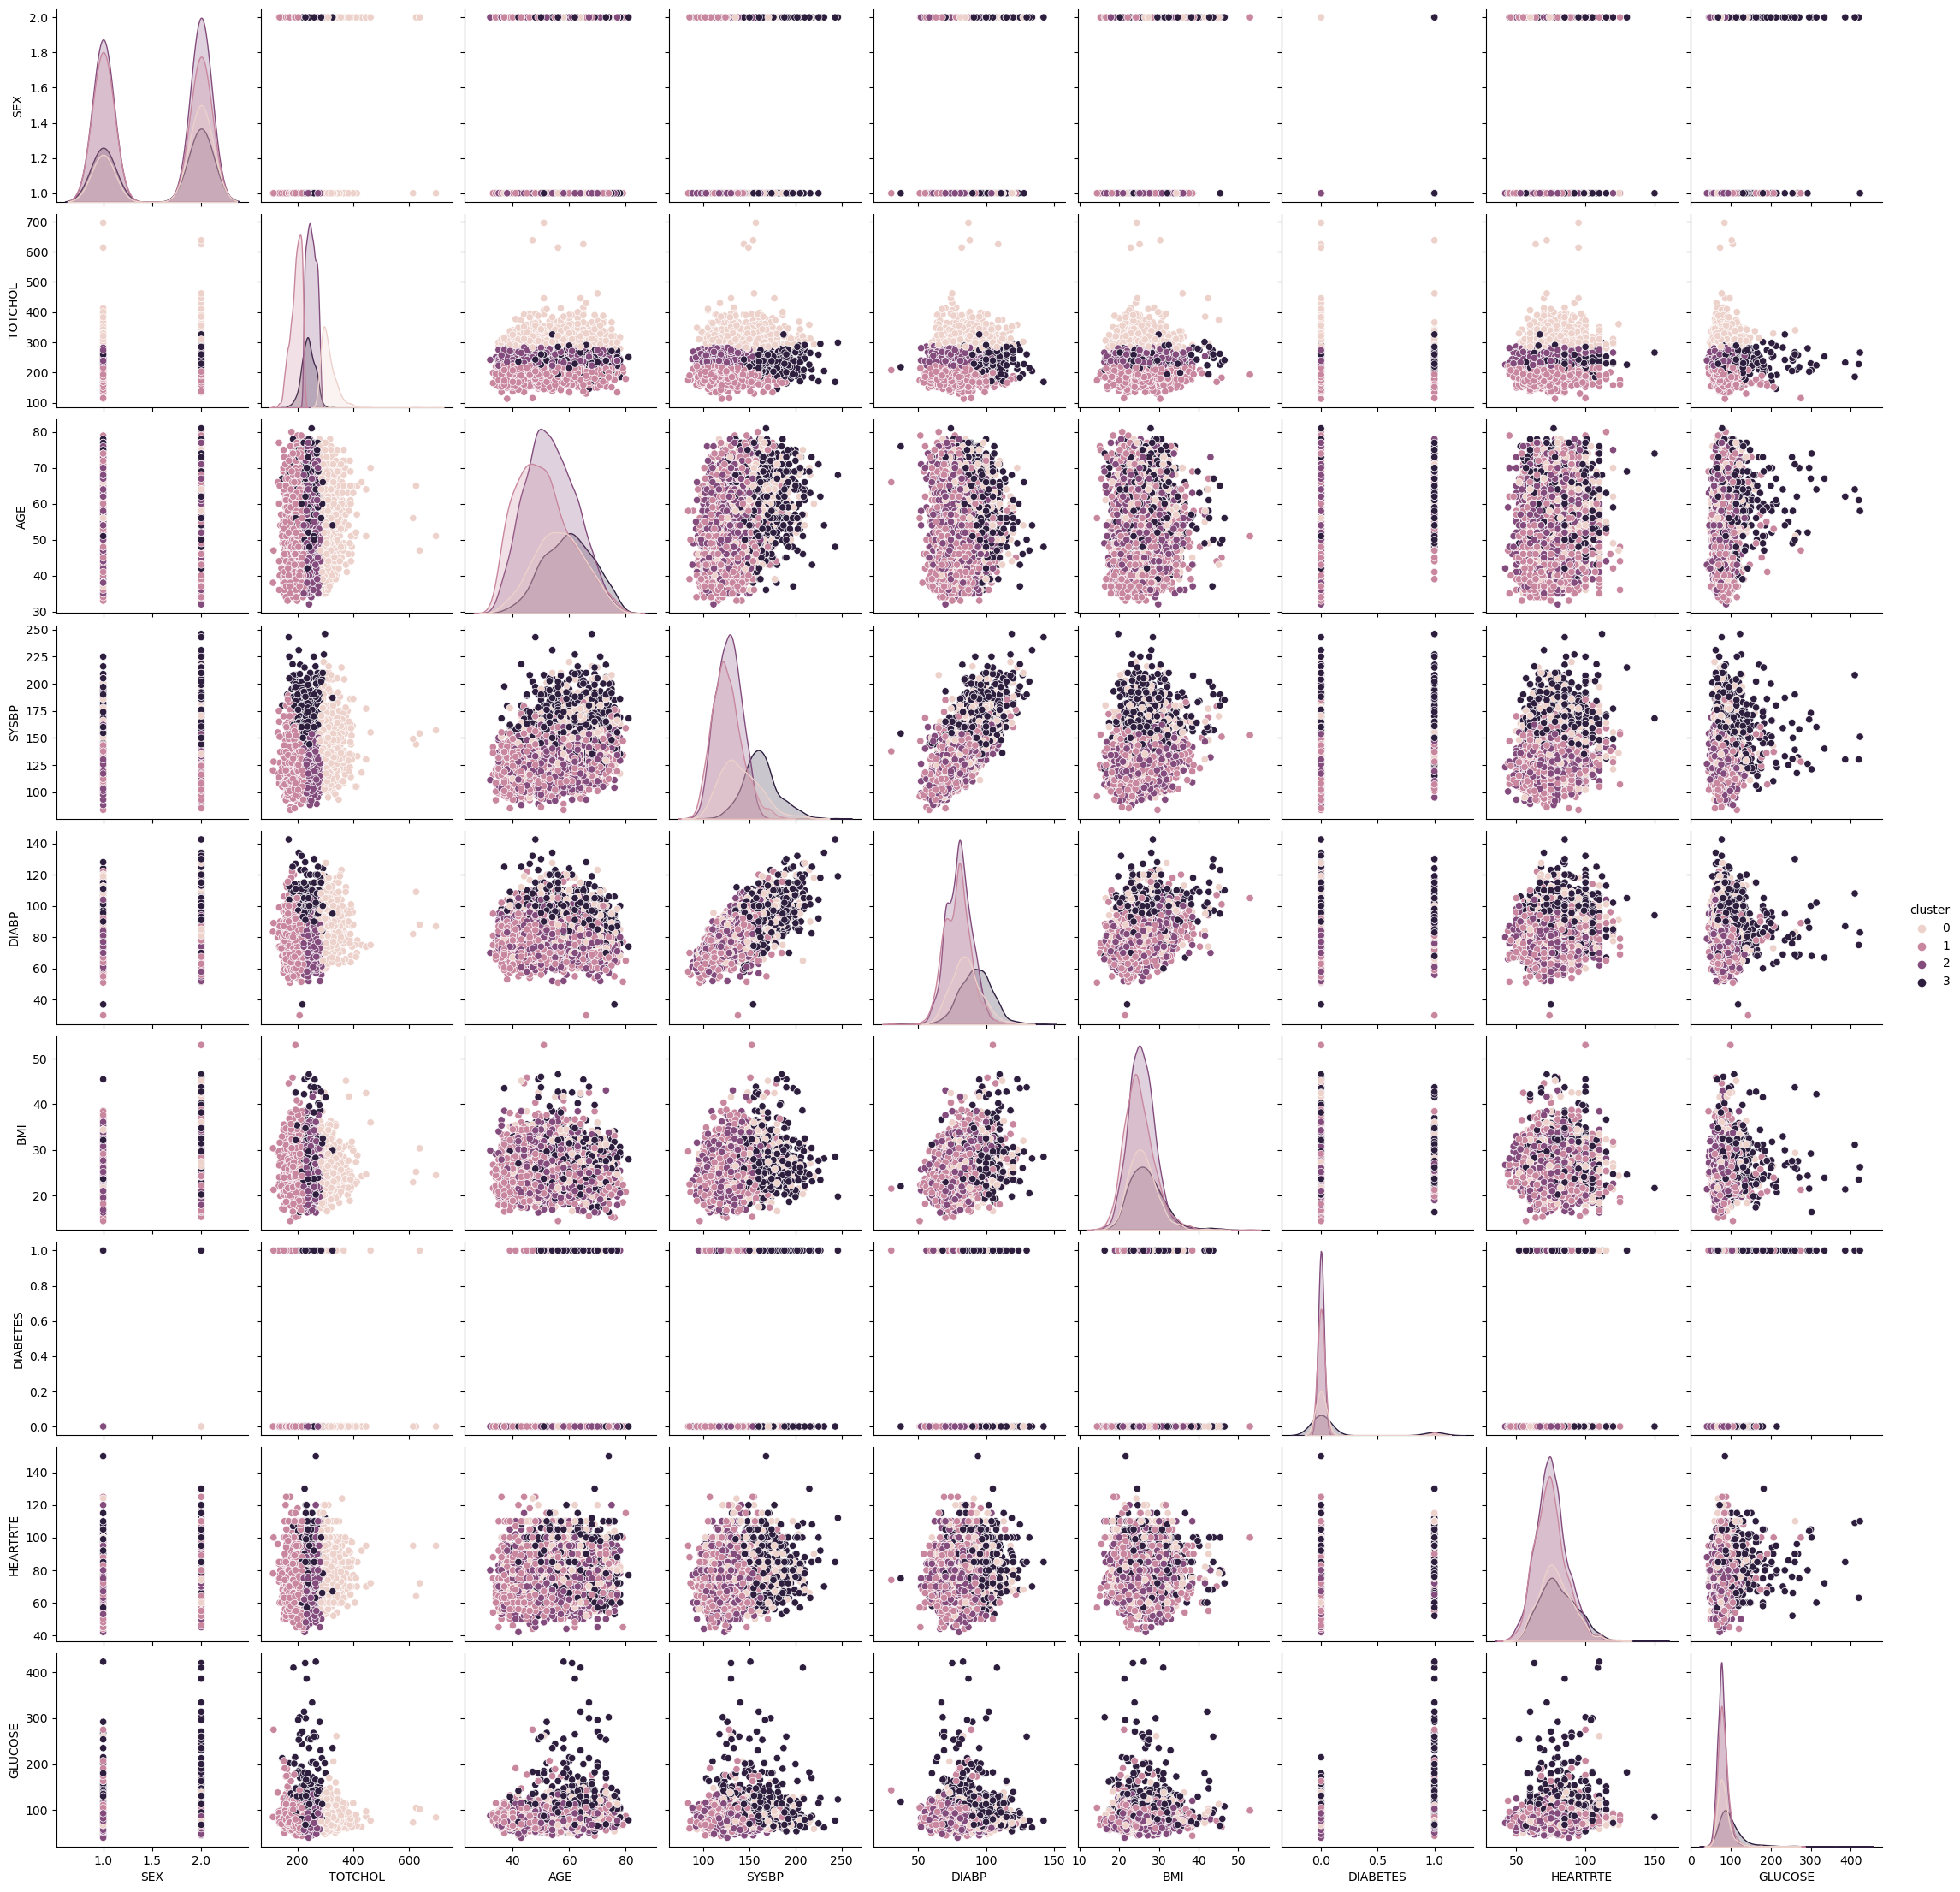

In [16]:
sns.pairplot(df_num, hue = 'cluster')

## Dimension Reduction 

In [41]:
umap = UMAP(n_neighbors=50)
um = umap.fit_transform(X)

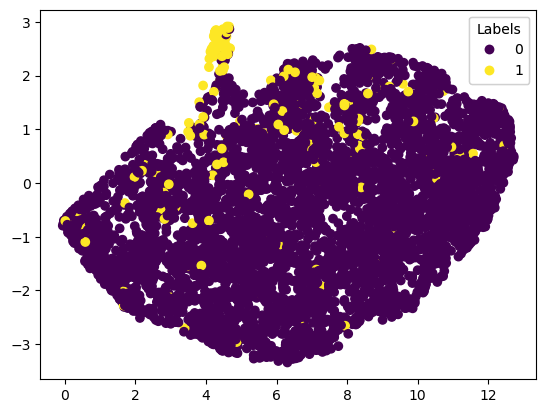

In [42]:
um1 = um[:,0]
um2 = um[:,1]
labels = y.astype(int)
fig, ax = plt.subplots()
scatter = ax.scatter(um1, um2, c=labels)

legend = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Labels")
ax.add_artist(legend)